In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
from model_graph import densenet_mnist
os.environ["CUDA_VISIBLE_DEVICES"]='1'
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 3], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')
shortcut_flag = tf.placeholder(tf.bool, name='shortcut')

In [3]:
output, feature_transform = densenet_mnist(inputs, 3, 40, 12, 1.0,
                                     train_flag,shortcut_flag, input_shortcut)

In [4]:
#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_adam = tf.train.AdamOptimizer(1e-4).minimize(cost)
step_momentum = tf.train.MomentumOptimizer(0.001, 0.9).minimize(cost)
step_gd = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

In [5]:
def get_3_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index_2 = np.where(label==2)[0]
    index = list(index_0)+list(index_1)+list(index_2)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 3)
    return images, label

In [6]:
batch_size = 1024
def optimize(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_3_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, 
                          train_flag: True, 
                          shortcut_flag: False,
                          input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoch: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_resnet_3_class_mom_{}.ckpt'.format(i))

In [7]:
optimize(step_adam, 1000)

('Epoch: 1/100', '| Training accuracy: ', 0.5897436, '| Cost: 1.09704113007', ' | Time for epoch: 62.06s')
('Epoch: 2/100', '| Training accuracy: ', 0.9305994, '| Cost: 0.804601550102', ' | Time for epoch: 43.98s')
('Epoch: 3/100', '| Training accuracy: ', 0.9873817, '| Cost: 0.443068921566', ' | Time for epoch: 31.66s')
('Epoch: 4/100', '| Training accuracy: ', 0.99697876, '| Cost: 0.404697030783', ' | Time for epoch: 32.18s')
('Epoch: 5/100', '| Training accuracy: ', 0.9939209, '| Cost: 0.395391106606', ' | Time for epoch: 34.35s')
('Epoch: 6/100', '| Training accuracy: ', 0.9967845, '| Cost: 0.39016097784', ' | Time for epoch: 29.71s')
('Epoch: 7/100', '| Training accuracy: ', 0.9935691, '| Cost: 0.384128630161', ' | Time for epoch: 34.36s')
('Epoch: 8/100', '| Training accuracy: ', 1.0, '| Cost: 0.38056448102', ' | Time for epoch: 29.16s')
('Epoch: 9/100', '| Training accuracy: ', 0.99999994, '| Cost: 0.377650350332', ' | Time for epoch: 27.40s')
('Epoch: 10/100', '| Training accur

('Epoch: 79/100', '| Training accuracy: ', 1.0, '| Cost: 0.231916591525', ' | Time for epoch: 26.85s')
('Epoch: 80/100', '| Training accuracy: ', 1.0, '| Cost: 0.230320811272', ' | Time for epoch: 27.36s')
('Epoch: 81/100', '| Training accuracy: ', 1.0, '| Cost: 0.22834174335', ' | Time for epoch: 26.81s')
('Epoch: 82/100', '| Training accuracy: ', 0.99999994, '| Cost: 0.227230876684', ' | Time for epoch: 27.00s')
('Epoch: 83/100', '| Training accuracy: ', 1.0, '| Cost: 0.225583046675', ' | Time for epoch: 27.32s')
('Epoch: 84/100', '| Training accuracy: ', 1.0, '| Cost: 0.223299428821', ' | Time for epoch: 28.66s')
('Epoch: 85/100', '| Training accuracy: ', 1.0, '| Cost: 0.221959710121', ' | Time for epoch: 26.96s')
('Epoch: 86/100', '| Training accuracy: ', 0.9999999, '| Cost: 0.220413312316', ' | Time for epoch: 27.53s')
('Epoch: 87/100', '| Training accuracy: ', 1.0000001, '| Cost: 0.218112230301', ' | Time for epoch: 27.37s')
('Epoch: 88/100', '| Training accuracy: ', 1.0, '| Cost

In [8]:
# check the test dataset performance
acc_list = []
for ii in range(mnist_data.test.num_examples//batch_size):
    batch = mnist_data.test.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_3_class(imgs, labs)

    dict_input = {inputs:imgs, targets:labs, 
                  train_flag: False, 
                  shortcut_flag: False,
                  input_shortcut: np.zeros([batch_size, 2])}

    acc = session.run(accuracy, feed_dict=dict_input)
    acc_list.append(acc)
print("Test accuracy: {}".format(np.mean(acc_list)))

Test accuracy: 0.996857762337


In [12]:
def plot_temp_all_3(feature, label, feature_t, label_t, 
                    name=None):
    pylab.figure()
    red = feature[label == 0]
    blue = feature[label == 1]
    c = feature[label == 2]
    green = feature_t[label_t == 0]
    black = feature_t[label_t == 1]
    yellow = feature_t[label_t == 2]

    pylab.plot(red[:, 0], red[:, 1], 'r.')
    pylab.plot(blue[:, 0], blue[:, 1], 'b.')
    pylab.plot(c[:, 0], c[:,1], 'c.')
    pylab.plot(green[:, 0], green[:, 1], 'g.')
    pylab.plot(black[:, 0], black[:, 1], 'k.')
    pylab.plot(yellow[:, 0], yellow[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)
def random_points_3(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(3,size)
	return feature, label

def get_svm(feature, label):
    from sklearn.svm import LinearSVC
    clf = LinearSVC(multi_class='ovr')
    clf.fit(feature, label)
    return clf

def plot_blobs_3(feature_t, label_t, 
                    name=None):
    pylab.figure()

    green = feature_t[label_t == 0]
    black = feature_t[label_t == 1]
    yellow = feature_t[label_t == 2]

    pylab.plot(green[:, 0], green[:, 1], 'g.')
    pylab.plot(black[:, 0], black[:, 1], 'k.')
    pylab.plot(yellow[:, 0], yellow[:, 1], 'y.')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)

In [13]:
feature_t = []
label_t = []

for ii in range(mnist_data.train.num_examples//batch_size):
    batch = mnist_data.train.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_3_class(imgs, labs)
    label_t.append(labs)
    
    dict_input = {inputs:imgs, targets:labs, 
                  train_flag: False, 
                  shortcut_flag: False,
                  input_shortcut: np.zeros([batch_size, 2])}

    feature_t.append(session.run(feature_transform, feed_dict=dict_input))

label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)

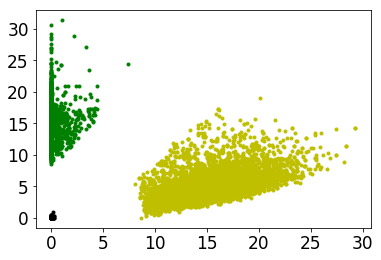

In [14]:
plot_blobs_3(feature_t, label_t)

# transformed space

In [16]:
feature_random, label_random = random_points_3(-10,
    40,-10,40, 30000,
    random_state=100)
label_random = to_categorical(label_random, 3)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               shortcut_flag: True,
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

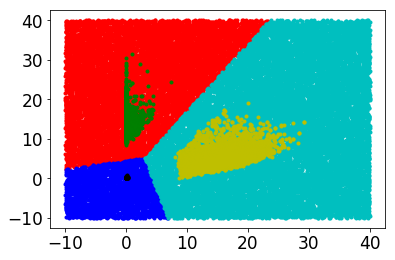

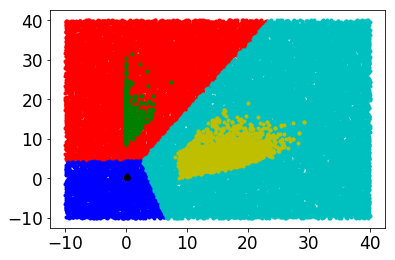

In [17]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t)

In [18]:
plot_temp_all_3(feature_random, pre_label_nn,feature_t, label_t, '../result/mnist_3_class_densenet/nn_transformed.png')
plot_temp_all_3(feature_random, pre_label_svm,feature_t, label_t, '../result/mnist_3_class_densenet/svm_transformed.png')